# Поиск токсичных комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Подготовка

### 1.1. Загрузка данных

In [1]:
!pip install spacy -q
!python -m spacy download en_core_web_sm
!pip install Pillow==9.5.0 -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 17.7 MB/s  0:00:00 eta 0:00:01

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Импортируем библиотеки

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from lightgbm import LGBMClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

import spacy
import warnings
import os
from wordcloud import WordCloud

pd.set_option('display.max_columns', None)

In [3]:
# Зададим значения RANDOM_STATE и TEST_SIZE

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Игрорируем предупреждения

warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# Загрузим файлы

base_url = "https://huggingface.co/datasets/onejetpilot/toxic_comments/resolve/main/"

files = [
    ("toxic_comments.csv", "toxic_comments.csv")
]

for filename, local_path in files:
    if not os.path.exists(local_path):
        print(f"Файл {filename} не найден — начинаю скачивание...")

        file_url = base_url + filename
        response = requests.get(file_url, stream=True)

        if response.status_code == 200:
            with open(local_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Файл успешно скачан: {local_path}")
        else:
            print(f"Ошибка при скачивании {filename}: {response.status_code}")
    else:
        print(f"Файл {filename} уже есть локально — загрузка пропущена")


data = pd.read_csv('toxic_comments.csv')

print("Все файлы успешно загружены в DataFrame")

Файл toxic_comments.csv уже есть локально — загрузка пропущена
Все файлы успешно загружены в DataFrame


In [6]:
# Посмотрим на наши данные

data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
# Проверим пропуски и дубликаты
    
d = '-' * 50
    
print(d)
print('Инфо')
print(d)
print(data.info())
print('\n')
    
print(d)
print('Пропуски')
print(d)
print(data.isna().sum())
print('\n')
    
print(d)
print('Дубликаты')
print(d)
print(data.duplicated().sum())
print('\n')

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


--------------------------------------------------
Пропуски
--------------------------------------------------
text     0
toxic    0
dtype: int64


--------------------------------------------------
Дубликаты
--------------------------------------------------
0




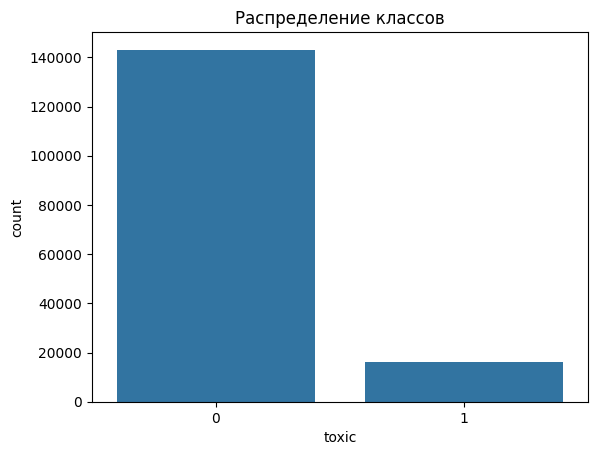

In [8]:
# Нарисуем график распределния классов

sns.countplot(x='toxic', data=data)
plt.title('Распределение классов')
plt.show()

Как можно увидеть по графику, у нас сильный дисбаланс классов.

### 1.2. Подготовка

In [9]:
# Определим лемматизатор

lemmatizer = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [10]:
def lemmatize_text(text: str) -> str:
    """
    Приводит текст к нижнему регистру, очищает от не-латинских символов,
    лемматизирует с помощью spaCy и удаляет стоп-слова.

    Параметры
    ----------
    text : str
        Исходный текст для обработки.

    Возвращает
    ----------
    str
        Лемматизированный текст, состоящий из очищенных лемм,
        соединённых пробелами.
    """
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', " ", text)
    doc = lemmatizer(text)
    tokens: List[str] = [
        token.lemma_
        for token in doc
        if not token.is_stop
        and not token.is_space
        and len(token) > 2
    ]

    return " ".join(tokens)

In [11]:
# Применим лемматизацию к стобцу с описаниями

data['lemm_text'] = data['text'].apply(lemmatize_text)

In [12]:
# Посмотрим результат до и после лемматизации

pd.set_option('max_colwidth', 200)
data[['text', 'lemm_text']].head(10)

,text,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",explanation edit username hardcore metallica fan revert weren vandalism closure gas vote new york dolls fac don remove template talk page retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",aww match background colour seemingly stuck thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",hey man try edit war guy constantly remove relevant information talk edit instead talk page care formatting actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",real suggestion improvement wonder section statistic later subsection type accident think reference need tidy exact format date format etc later preference formatting style reference want let know...
4,"You, sir, are my hero. Any chance you remember what page that's on?",sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,congratulation use tool talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,cocksucker piss work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",vandalism matt shirvington article revert don ban
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encycl...",sorry word nonsense offensive intend write article wow jump vandalism merely request encyclopedic use school reference selective breeding page stub point animal breeding short messy article give i...
9,alignment on this subject and which are contrary to those of DuLithgow,alignment subject contrary dulithgow


### 1.3. Визуализация

In [13]:
# Разделим корпуса по классам

toxic_texts = " ".join(data.loc[data['toxic'] == 1, 'lemm_text']).split()
nontoxic_texts = " ".join(data.loc[data['toxic'] == 0, 'lemm_text']).split()

In [14]:
# Посчитаем частоты для топ-20 слов

toxic_counts = Counter(toxic_texts).most_common(20)
nontoxic_counts = Counter(nontoxic_texts).most_common(20)

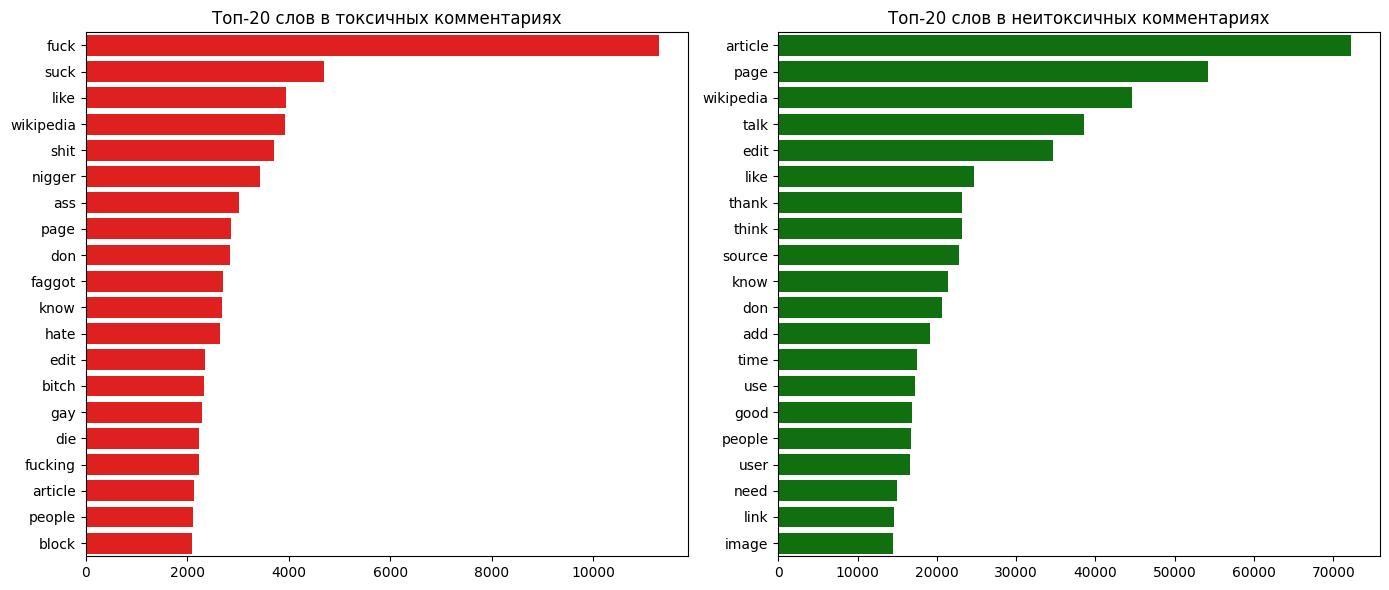

In [15]:
# Построим графики топ-слов в каждом классе

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=[c for _, c in toxic_counts], y=[w for w, _ in toxic_counts], ax=axes[0], color='red')
axes[0].set_title('Топ-20 слов в токсичных комментариях')
sns.barplot(x=[c for _, c in nontoxic_counts], y=[w for w, _ in nontoxic_counts], ax=axes[1], color='green')
axes[1].set_title('Топ-20 слов в неитоксичных комментариях')
plt.tight_layout()
plt.show()

Частотный анализ показывает, что токсичные комментарии опираются на ограниченный набор повторяющихся слов, тогда как нетоксичные более разнообразны по лексике. 

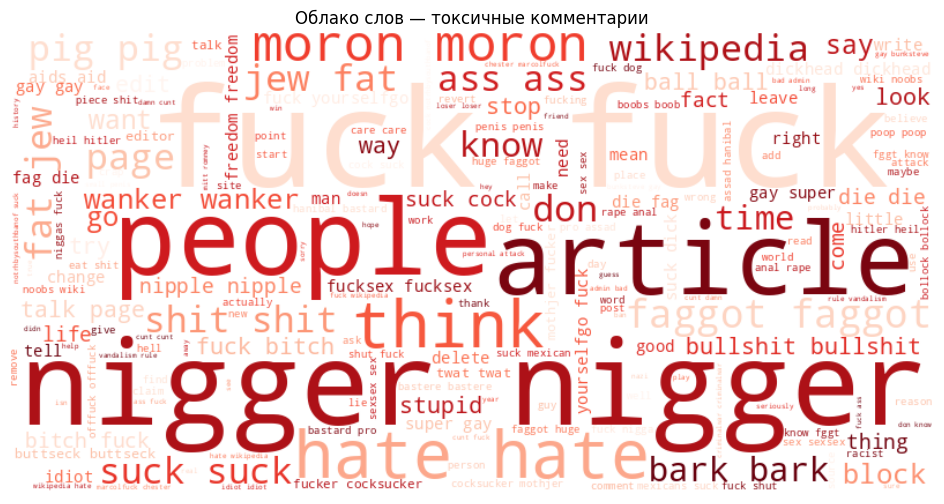

In [16]:
# Облако слов в токсичных комментариях

toxic_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(" ".join(toxic_texts))
plt.figure(figsize=(12,6))
plt.imshow(toxic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов — токсичные комментарии')
plt.show()

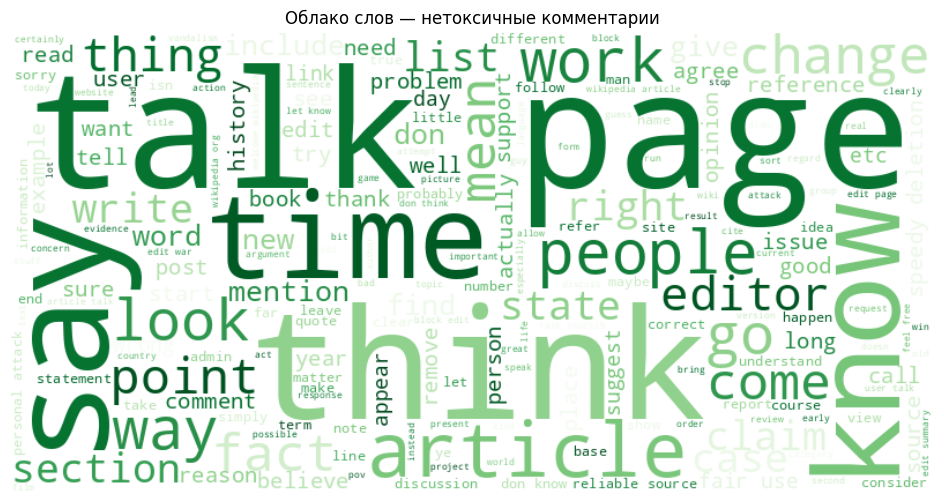

In [17]:
# Облако слов в нетоксичных комментариях

nontoxic_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(" ".join(nontoxic_texts))
plt.figure(figsize=(12,6))
plt.imshow(nontoxic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов — нетоксичные комментарии')
plt.show()

Сравнение облаков слов показывает резкий контраст
- токсичные комментарии концентрируются вокруг грубых оскорблений
- нетоксичные комментарии наполнены словами, связанными с обсуждением и редактированием

In [18]:
# Разделим датасет на выборки

X = data['lemm_text']
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [19]:
# Определим TF-IDF векторизатор

vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1,2))

### Вывод

Подготовили данные для обучения — выполнили очистку, лемматизацию, удаление стоп-слов, разделили датасет на train/test и представили тексты в виде TF-IDF матрицы признаков, готовой для обучения.

Частотный анализ показывает, что токсичные комментарии опираются на ограниченный набор повторяющихся слов, тогда как нетоксичные более разнообразны по лексике. 

Сравнение облаков слов показывает резкий контраст
- токсичные комментарии концентрируются вокруг грубых оскорблений
- нетоксичные комментарии наполнены словами, связанными с обсуждением и редактированием

## 2. Обучение

In [20]:
# Создадим функцию для оценки качества модели

def eval_and_print(name, y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    print(f'{name}: F1 = {f1:.4f}')
    print(classification_report(y_true, y_pred, digits=3))

In [21]:
# Определим кросс-валидацию по 5 сплитам

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [22]:
# Создадим пайплайн для Logistic Regression

pipe_lr = Pipeline([
    ("tfidf", vectorizer),
    ("clf", LogisticRegression(
        solver="saga",
        class_weight="balanced",
        max_iter=2000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

In [23]:
# Создадим пайплайн для LinearSVC

pipe_svm = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LinearSVC(
        class_weight='balanced',
        max_iter=20000,
        C=0.25,
        loss='squared_hinge',
        random_state=RANDOM_STATE
    ))
])

In [24]:
# Обучим Logistic Regression на кросс валидации

cv_f1_lr = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
print(f"\nLogReg — CV F1: {cv_f1_lr.mean():.4f}")


LogReg — CV F1: 0.7519


In [25]:
# Обучим LinearSVC на кросс валидации

cv_f1_svm = cross_val_score(pipe_svm, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
print(f"\nLinearSVC — CV F1: {cv_f1_svm.mean():.4f}")


LinearSVC — CV F1: 0.7569


LinearSVC показала лучший результат на кросс-валидации, поэтому будем использовать ее.

In [26]:
# Обучим лучшую модель на всем датасете и посчитаем F1 на тестовой выборке

pipe_svm.fit(X_train, y_train)
eval_and_print("LinearSVC", y_test, pipe_svm.predict(X_test))

LinearSVC: F1 = 0.7563
              precision    recall  f1-score   support

           0      0.981     0.957     0.969     35777
           1      0.689     0.839     0.756      4046

    accuracy                          0.945     39823
   macro avg      0.835     0.898     0.863     39823
weighted avg      0.952     0.945     0.947     39823



### Вывод

Сравнение Logistic Regression и LinearSVC показало, что LinearSVC лучше справляется с задачей по метрике F1, что позволяет выбрать её в качестве финального решения.

## Общий вывод

Модель LinearSVC показала итоговую метрику F1 = 0.7563, что превышает минимальное требование задачи (F1 ≥ 0.75).
- Для нетоксичных комментариев (класс 0) качество очень высокое: precision = 0.981, recall = 0.957, f1 = 0.969.
- Для токсичных комментариев (класс 1) показатели ниже, но приемлемые: precision = 0.689, recall = 0.839, f1 = 0.756. Это значит, что модель чаще находит токсичные комментарии (высокий recall), но иногда ошибочно относит нетоксичные к токсичным.